In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random

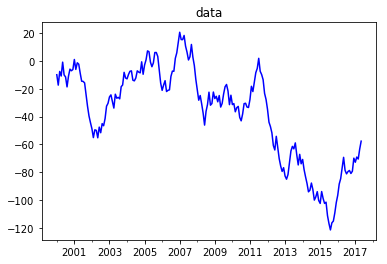

2000-01-31    -9.998559
2000-02-29   -17.458741
2000-03-31    -7.655730
2000-04-30   -10.940996
2000-05-31    -0.988769
2000-06-30   -10.142709
2000-07-31   -11.625702
2000-08-31   -18.732608
2000-09-30   -10.995456
2000-10-31    -5.999378
Freq: M, dtype: float64

In [74]:
random.seed(50)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10,10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='data')
plt.show()
ts.head(10)

In [75]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)


10
(10, 20, 1)
[[[ -9.99855865]
  [-17.45874124]
  [ -7.65573043]
  [-10.94099581]
  [ -0.98876912]
  [-10.14270888]
  [-11.62570168]
  [-18.73260793]
  [-10.99545584]
  [ -5.99937787]
  [ -7.15669648]
  [ -6.24326613]
  [  0.91750735]
  [ -6.20050957]
  [ -1.44506334]
  [ -2.43805853]
  [ -8.90239752]
  [-14.6578076 ]
  [-14.79391763]
  [-15.85637347]]

 [[-24.40709814]
  [-32.60309593]
  [-39.5340832 ]
  [-44.33801915]
  [-48.71028777]
  [-55.08231359]
  [-49.51861489]
  [-49.86767402]
  [-55.23023955]
  [-47.57092033]
  [-51.59754544]
  [-45.07447198]
  [-46.57931587]
  [-41.43907675]
  [-32.54837642]
  [-30.5287546 ]
  [-25.93187141]
  [-24.46482227]
  [-29.33659953]
  [-33.9199756 ]]]
[[[-17.45874124]
  [ -7.65573043]
  [-10.94099581]
  [ -0.98876912]
  [-10.14270888]
  [-11.62570168]
  [-18.73260793]
  [-10.99545584]
  [ -5.99937787]
  [ -7.15669648]
  [ -6.24326613]
  [  0.91750735]
  [ -6.20050957]
  [ -1.44506334]
  [ -2.43805853]
  [ -8.90239752]
  [-14.6578076 ]
  [-14.79391

In [69]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX,testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ -4.71820872]
  [ 15.95333495]
  [  8.14269867]
  [ 10.08485784]
  [ 37.02122667]
  [ 19.60235691]
  [ 16.81954202]
  [  6.86738033]
  [-11.25867254]
  [-22.23579639]
  [-20.51384225]
  [ -9.79112931]
  [-22.36994166]
  [-14.53442339]
  [  2.85372127]
  [ 17.95773194]
  [ 23.09995551]
  [ 22.27958142]
  [ 14.72096695]
  [ 14.74096775]]]


In [87]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 10
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.tanh)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.0001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [88]:
epochs = 80000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 500 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 495559.0
500 	MSE: 487268.0
1000 	MSE: 471202.0
1500 	MSE: 461414.0
2000 	MSE: 442343.0
2500 	MSE: 431451.0
3000 	MSE: 423662.0
3500 	MSE: 416587.0
4000 	MSE: 409624.0
4500 	MSE: 402769.0
5000 	MSE: 396020.0


KeyboardInterrupt: 

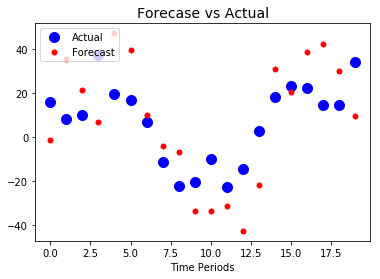

In [86]:
plt.title("Forecase vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()
